## ERA Session7 Assignment: Model3
### Target
 - Last model was showing scope for learning
 - So Trying to increase the training accuracy and maintain before attempting to reduce the number of parameters again
 - Use BatchNormalization to improve train and test accuracies
 - Add drop out so the gap between train and test accuracies reduce

### Results
 - No. of Params: 17,584
 - Best Test Accuracy: 99.42%
 - Best Train Accuracy: 99.53%

### Analysis
 - Number of parametrs increased a bit from 17360 to 17584
 - Gap in accuracy is reduced very much
 - Consistently accuracy is at 99.4+
 - Adding BatchNormalization helped to improve the training accuracy
 - Adding Dropout reduced a bit of overfitting and the gap beween train and test accuracies reduced


In [19]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [20]:
from models import Model3 as Model

In [21]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                    #    transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [22]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [23]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Model().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             512
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           2,304
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [25]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
  epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [26]:
model =  Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.079708032310009 Batch_id=468 Accuracy=95.25: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0521, Accuracy: 9836/10000 (98.36%)

EPOCH: 2


Loss=0.07851333916187286 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0317, Accuracy: 9901/10000 (99.01%)

EPOCH: 3


Loss=0.04704216495156288 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]



Test set: Average loss: 0.0282, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.08346319198608398 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:19<00:00, 23.91it/s]



Test set: Average loss: 0.0256, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.031770531088113785 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]



Test set: Average loss: 0.0268, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.05620526894927025 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]



Test set: Average loss: 0.0244, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.0028100451454520226 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]



Test set: Average loss: 0.0243, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.01926765963435173 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]



Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.028752489015460014 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]



Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.01571882702410221 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.004480002913624048 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]



Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.010488367639482021 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]



Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.0027576861903071404 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.043154846876859665 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]



Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.023096973076462746 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

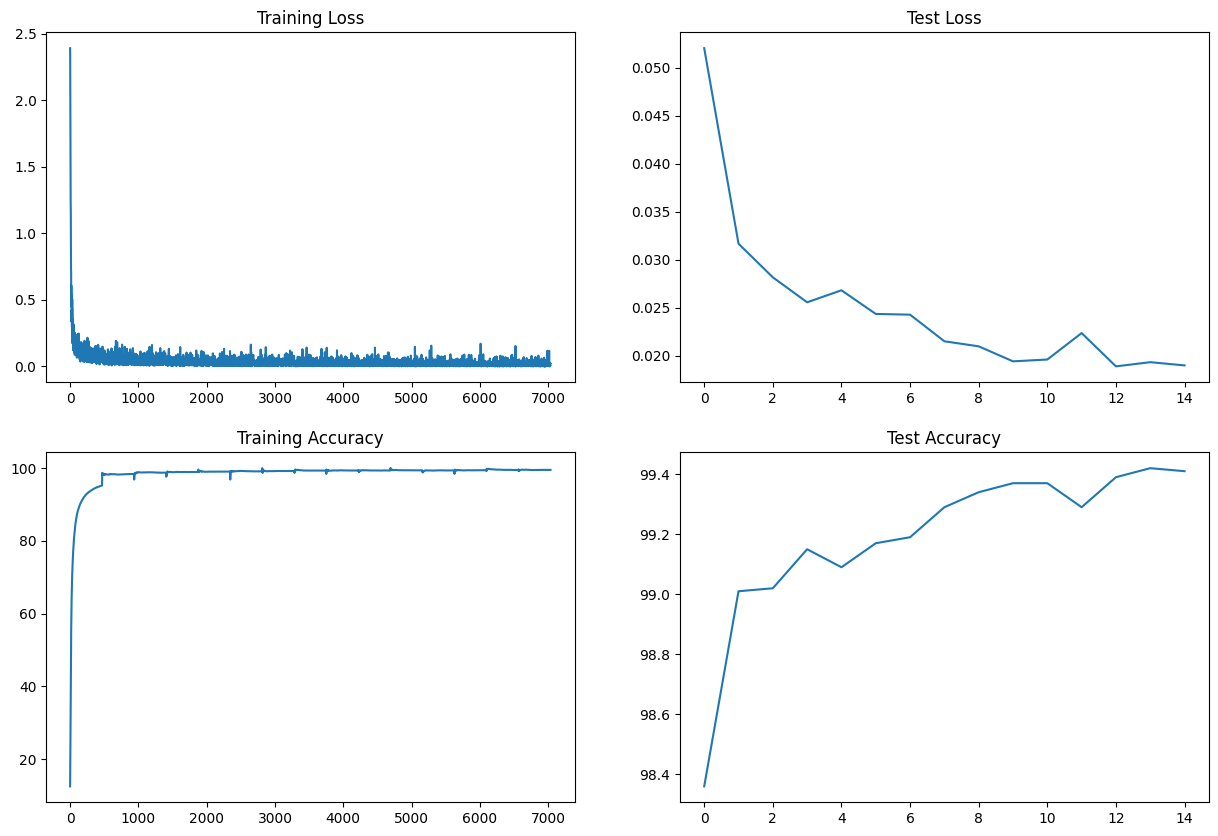

In [27]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")